<a href="https://colab.research.google.com/github/rndjv/pospucav1/blob/main/codigo/mvp1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP de Análise de Dados e Boas Práticas

##1. Definição do Problema

O dataset utilizado será o da empresa Backblaze, que oferece serviços de armazenamento na nuvem com mais de 3 bilhões de gigabytes de armazenamento. Anualmente são publicadas estatísticas e insights baseadas nos discos rígidos do data center da companhia.
Todo disco possui um sistema de monitoramento denominado SMART(Self-Monitoring, Analysis, and Reporting Technology), que detecta e relata vários indicadores da unidade, visando a antecipação de falhas.

Todos os dias, no data center Backblaze, um instantâneo de cada disco rígido operacional é retirado. Este instantâneo inclui informações básicas da unidade junto com as S.M.A.R.T. estatísticas relatadas por essa unidade. O instantâneo diário de uma unidade é um registro ou linha de dados. Todos os instantâneos de unidades de um determinado dia são coletados em um arquivo que consiste em uma linha para cada disco rígido ativo.

As colunas são as seguintes:

- Data – A data do arquivo no formato aaaa-mm-dd.
- Número de série – O número de série da unidade atribuído pelo fabricante.
-  Modelo – O número do modelo da unidade atribuído pelo fabricante.
-  Capacidade – A capacidade da unidade em bytes.
-  Falha – Contém um “0” se a unidade estiver OK. Contém “1” se este for o último dia em que a unidade esteve operacional antes de falhar.
-  Estatísticas SMART – 80 colunas de dados, que são os valores brutos e normalizados para 40 estatísticas SMART diferentes, conforme relatado por uma determinada unidade. Cada valor é o número relatado pela unidade.

As estatísticas SMART não tem a definição facilmente localizadas e nem universalmente aceitas, podendo variar de fabricante para fabricante.
A Backblaze fornece os seguinte significados para as presentes no dataset:
- smart_1:Read Error Rate
- smart_2:Throughput Performance
- smart_3:Spin-Up Time
- smart_4:Start/Stop Count
- smart_5:Reallocated Sectors Count
- smart_7:Seek Error Rate
- smart_8:Seek Time Performance
- smart_9:Power-On Hours
- smart_10:Spin Retry Count
- smart_11:Recalibration Retries
- smart_12:Power Cycle Count
- smart_13:Soft Read Error Rate
- smart_15:Não Fornecido
- smart_183:Runtime Bad Block
- smart_184:End-to-End error
- smart_187:Reported Uncorrectable Errors
- smart_188:Command Timeout
- smart_189:High Fly Writes
- smart_190:Temperature Difference
- smart_191:G-sense Error Rate
- smart_192:Power-off Retract Count
- smart_193:Load Cycle Count
- smart_194:Temperature
- smart_195:Hardware ECC Recovered
- smart_196:Reallocation Event Count
- smart_197:Current Pending Sector Count
- smart_198:(Offline) Uncorrectable Sector Count
- smart_199:UltraDMA CRC Error Count
- smart_200:Multi-Zone Error Rate
- smart_201:Soft Read Error Rate
- smart_223:Load/Unload Retry Count
- smart_225:Load/Unload Cycle Count
- smart_240:Head Flying Hours
- smart_241:Total LBAs Written
- smart_242:Total LBAs Read
- smart_250:Read Error Retry Rate
- smart_251:Minimum Spares Remaining
- smart_252:Newly Added Bad Flash Block
- smart_254:Free Fall Protection
- smart_255:Não Fornecido

Sendo um dataset com indicação de último dia antes de falha, com estatísticas que descrevem a unidade, o problema poderia ser de aprendizado supervisionado. Se utilizando das SMART estatísticas como entrada e a falha como saída do modelo

In [107]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from datetime import date, timedelta
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder


In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2. Carga de Dados

Os dados fornecidos são separados por dias de um inteiro, foram realizados testes para a utilização do dataset do ano inteiro mas a capacidade de RAM do COLAB foi excedida. Assim, para a realização do MVP foram utilizados dados dos meses de outubro, novembro e dezembro; os arquivos foram armazenados no github separados por dias.

O código abaixo cria uma lista entre as datas início e fim, incrementado em um dia e utilizando essas datas para realizar a leitura do arquivos no github.

In [ ]:
start_dt = date(2013, 10, 1)
end_dt = date(2013, 12, 31)

# diferença entre datas
delta = timedelta(days=1)

# salvar datas na lista
dates = []

while start_dt <= end_dt:
    # adicionando data em iso format e adicionando a extensão csv e salvando os arquivos
    dates.append('https://raw.githubusercontent.com/rndjv/pospucav1/main/dataset/'+str(start_dt.isoformat())+'.csv')
    # incremetando a data pelo timedelta
    start_dt += delta


In [ ]:
#criando um dataser vazio para ir adicionando as concatenações parciais dos arquivos diários
df = pd.DataFrame()
for arquivos in dates:
  df = pd.concat([df, pd.read_csv(arquivos)], ignore_index = True)
print(df.tail())

               date   serial_number                    model  capacity_bytes  \
2062038  2013-12-31  JK1101B9JPEMSR  Hitachi HDS722020ALA330   2000398934016   
2062039  2013-12-31  MJ1311YNG3G5NA  Hitachi HDS5C3030ALA630   3000592982016   
2062040  2013-12-31        Z290YFTA             ST33000651AS   3000592982016   
2062041  2013-12-31  MJ1323YNG1LZJC  Hitachi HDS5C3030ALA630   3000592982016   
2062042  2013-12-31        Z1F11BHF              ST3000DM001   3000592982016   

         failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
2062038        0                 NaN            0                 NaN   
2062039        0                 NaN            1                 NaN   
2062040        0                 NaN    103165300                 NaN   
2062041        0                 NaN       589824                 NaN   
2062042        0                 NaN     71366752                 NaN   

         smart_2_raw  smart_3_normalized  ...  smart_250_normalized  \
2062038  

## 3. Análise de Dados

### 3.1. Estatísiticas Descritivas

In [ ]:
#dimensões do dataset
print(df.shape)

(2062043, 85)


In [ ]:
#informações do datset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062043 entries, 0 to 2062042
Data columns (total 85 columns):
 #   Column                Dtype  
---  ------                -----  
 0   date                  object 
 1   serial_number         object 
 2   model                 object 
 3   capacity_bytes        int64  
 4   failure               int64  
 5   smart_1_normalized    float64
 6   smart_1_raw           int64  
 7   smart_2_normalized    float64
 8   smart_2_raw           float64
 9   smart_3_normalized    float64
 10  smart_3_raw           float64
 11  smart_4_normalized    float64
 12  smart_4_raw           float64
 13  smart_5_normalized    float64
 14  smart_5_raw           int64  
 15  smart_7_normalized    float64
 16  smart_7_raw           float64
 17  smart_8_normalized    float64
 18  smart_8_raw           float64
 19  smart_9_normalized    float64
 20  smart_9_raw           int64  
 21  smart_10_normalized   float64
 22  smart_10_raw          float64
 23  smart_1

In [ ]:
#primeiras 10 linhas
print(df.head(10))

         date   serial_number                    model  capacity_bytes  \
0  2013-10-01        W300D3HY              ST4000DM000   4000787030016   
1  2013-10-01  MJ1323YNG1MB4C  Hitachi HDS5C3030ALA630   3000592982016   
2  2013-10-01        W300BR20              ST4000DM000   4000787030016   
3  2013-10-01        W300CJ6Y              ST4000DM000   4000787030016   
4  2013-10-01  PL1331LAGB4EVH  Hitachi HDS5C4040ALE630   4000787030016   
5  2013-10-01        Z300MGNF              ST4000DM000   4000787030016   
6  2013-10-01        W30068RN              ST4000DM000   4000787030016   
7  2013-10-01        W300D3HL              ST4000DM000   4000787030016   
8  2013-10-01        Z300GQ68              ST4000DM000   4000787030016   
9  2013-10-01        W3005Q1G              ST4000DM000   4000787030016   

   failure  smart_1_normalized  smart_1_raw  smart_2_normalized  smart_2_raw  \
0        0                 NaN    166266536                 NaN          NaN   
1        0               

In [ ]:
#últimas 10 linhas
print(df.tail(10))

               date   serial_number                    model  capacity_bytes  \
2062033  2013-12-31  JK1101B9JPET8R  Hitachi HDS722020ALA330   2000398934016   
2062034  2013-12-31  PL1321LAG33P5H  Hitachi HDS5C4040ALE630   4000787030016   
2062035  2013-12-31  JK1101B9JNUX5F  Hitachi HDS722020ALA330   2000398934016   
2062036  2013-12-31        6XW018HW             ST31500541AS   1500301910016   
2062037  2013-12-31  MJ1323YNG1M6YC  Hitachi HDS5C3030ALA630   3000592982016   
2062038  2013-12-31  JK1101B9JPEMSR  Hitachi HDS722020ALA330   2000398934016   
2062039  2013-12-31  MJ1311YNG3G5NA  Hitachi HDS5C3030ALA630   3000592982016   
2062040  2013-12-31        Z290YFTA             ST33000651AS   3000592982016   
2062041  2013-12-31  MJ1323YNG1LZJC  Hitachi HDS5C3030ALA630   3000592982016   
2062042  2013-12-31        Z1F11BHF              ST3000DM001   3000592982016   

         failure  smart_1_normalized  smart_1_raw  smart_2_normalized  \
2062033        0                 NaN          

In [ ]:
#Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
df_describe = df.describe()
print(df_describe)

       capacity_bytes       failure  smart_1_normalized   smart_1_raw  \
count    2.062043e+06  2.062043e+06                 0.0  2.062043e+06   
mean     2.886334e+12  1.571257e-04                 NaN  5.534137e+07   
std      8.717447e+11  1.253400e-02                 NaN  7.849762e+07   
min      1.000205e+12  0.000000e+00                 NaN  0.000000e+00   
25%      2.000399e+12  0.000000e+00                 NaN  0.000000e+00   
50%      3.000593e+12  0.000000e+00                 NaN  2.000000e+01   
75%      4.000787e+12  0.000000e+00                 NaN  1.090546e+08   
max      4.000787e+12  1.000000e+00                 NaN  4.410211e+09   

       smart_2_normalized  smart_2_raw  smart_3_normalized  smart_3_raw  \
count                 0.0          0.0                 0.0          0.0   
mean                  NaN          NaN                 NaN          NaN   
std                   NaN          NaN                 NaN          NaN   
min                   NaN          NaN    

As colunas com valores normalizados serão deletadas para serem realizadas as análises nos dados originais

In [ ]:
#criando lista para armazenar os nomes de colunas contendo "normalized"
lista_colunas_normalizadas = []
for colunas in df.columns:
    if "normalized" in colunas:
        lista_colunas_normalizadas.append(colunas)

#deletando as colunas normalizadas
df_sem_colunas_normalizadas = df.drop(columns = lista_colunas_normalizadas)

#verificando a quantidade de nulls nas colunas
print(df_sem_colunas_normalizadas.isnull().sum())

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_1_raw             0
smart_2_raw       2062043
smart_3_raw       2062043
smart_4_raw       2062043
smart_5_raw             0
smart_7_raw       2062043
smart_8_raw       2062043
smart_9_raw             0
smart_10_raw      2062043
smart_11_raw      2062043
smart_12_raw      2062043
smart_13_raw      2062043
smart_15_raw      2062043
smart_183_raw     2062043
smart_184_raw     2062043
smart_187_raw     2062043
smart_188_raw     2062043
smart_189_raw     2062043
smart_190_raw     2062043
smart_191_raw     2062043
smart_192_raw     2062043
smart_193_raw     2062043
smart_194_raw           0
smart_195_raw     2062043
smart_196_raw     2062043
smart_197_raw           0
smart_198_raw     2062043
smart_199_raw     2062043
smart_200_raw     2062043
smart_201_raw     2062043
smart_223_raw     2062043
smart_225_raw     2062043
smart_240_raw     2062043
smart_241_ra

Como se pode perceber na análises anteriores, existem colunas que são compostas somente de valores nulos.Assim, não agregam valor para as análises, sendo deletadas

       capacity_bytes       failure   smart_1_raw   smart_5_raw   smart_9_raw  \
count    2.062043e+06  2.062043e+06  2.062043e+06  2.062043e+06  2.062043e+06   
mean     2.886334e+12  1.571257e-04  5.534137e+07  6.174800e+01  1.499052e+04   
std      8.717447e+11  1.253400e-02  7.849762e+07  1.359881e+03  1.068246e+04   
min      1.000205e+12  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%      2.000399e+12  0.000000e+00  0.000000e+00  0.000000e+00  6.331000e+03   
50%      3.000593e+12  0.000000e+00  2.000000e+01  0.000000e+00  1.332700e+04   
75%      4.000787e+12  0.000000e+00  1.090546e+08  0.000000e+00  2.284000e+04   
max      4.000787e+12  1.000000e+00  4.410211e+09  6.538400e+04  2.604250e+05   

       smart_194_raw  smart_197_raw  
count   2.062043e+06   2.062043e+06  
mean    2.523600e+01   7.445751e+00  
std     3.824976e+00   6.235277e+02  
min     9.000000e+00   0.000000e+00  
25%     2.300000e+01   0.000000e+00  
50%     2.500000e+01   0.000000e+00  
75% 

<Axes: >

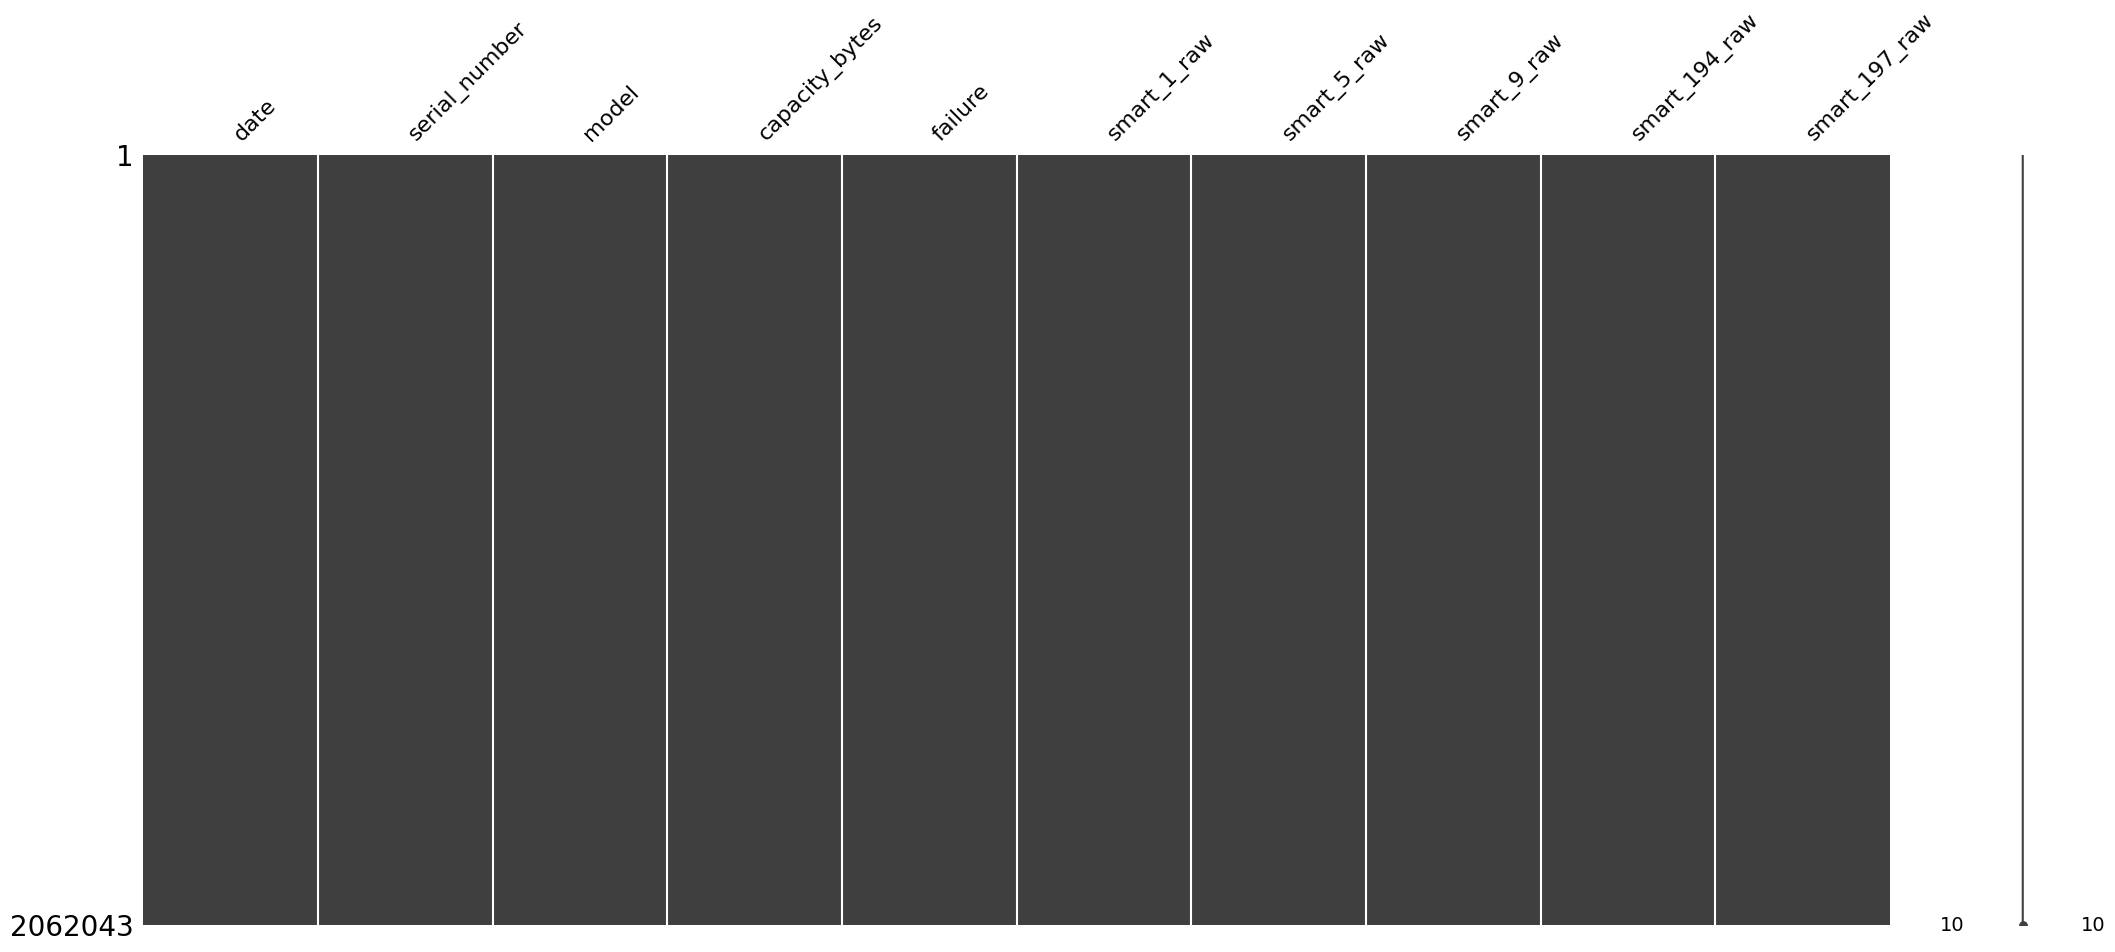

In [113]:
#deletendo colunas com todos os valores nulos
df_sem_colunas_normalizadas_dropna_columns = df_sem_colunas_normalizadas.dropna(axis = 1, how= "all")
#resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
print(df_sem_colunas_normalizadas_dropna_columns.describe())
ms.matrix(df_sem_colunas_normalizadas_dropna_columns)

1.000205e+12  
2.000399e+12  
3.000593e+12
4.000787e+12

In [ ]:
#contando a quantidade de eventos falhas e não falhas
df_count_falhas = pd.DataFrame(df_sem_colunas_normalizadas_dropna_columns.groupby("failure").size()).reset_index()
print((df_count_falhas))
#plt.pie(df_count_falhas[0], df_count_falhas['failure'])


   failure        0
0        0  2061719
1        1      324


In [ ]:
#contagem da quantidade de modelos e de números de série no dataset
print('Quantidade de modelos diferntes = ',len(df_sem_colunas_normalizadas_dropna_columns['model'].unique()))
print('Quantidade de séries diferentes = ',len(df_sem_colunas_normalizadas_dropna_columns['serial_number'].unique()))

Quantidade de modelos diferntes =  40
Quantidade de séries diferentes =  27974


Nessa etapa iremos realizar a contagem de discos ativos(números de série) por modelo. Para isso serão aplicadas algumas transformações para se obter esse quantitativo

Text(0, 0.5, 'Modelos')

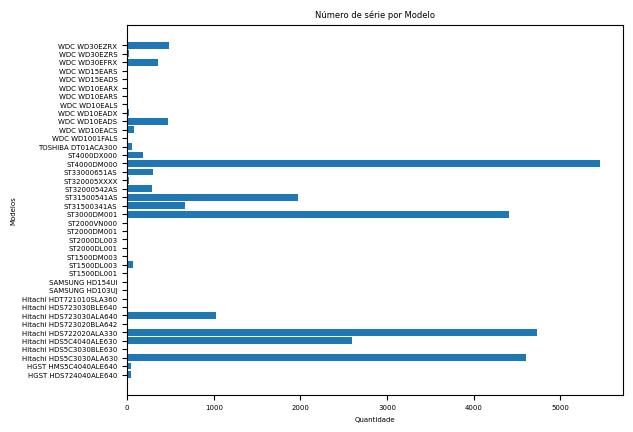

In [ ]:
#criando novo dataset somente com as colunas 'model' e 'serial_number'
df_sem_colunas_normalizadas_dropna_columns_modelo_serial = df_sem_colunas_normalizadas_dropna_columns.loc[:, ['model', 'serial_number']]

#juntando as colunas 'model' e 'serial_number' com um '_' em uma nova coluna nomeada 'model_serial_number'
#junção realizada para permitir a obtenção de quais serial_number pertencem a cada modelo
df_sem_colunas_normalizadas_dropna_columns_modelo_serial['model_serial_number'] = df_sem_colunas_normalizadas_dropna_columns_modelo_serial['model']+"_"+df_sem_colunas_normalizadas_dropna_columns_modelo_serial["serial_number"]

#criando uma lista com os valores únicos da coluna 'model_serial_number'
lista_model_serial = (list(df_sem_colunas_normalizadas_dropna_columns_modelo_serial["model_serial_number"].unique()))

#lista vazia criada para armazenar as linhas das lista anterior já novamente separadas
lista_model_serial_separado = []

#com os valoes únicos de 'model_serial_number' percorre-se toda a lista separando as colunas originais do '_'
for itens_lista_model_serial in lista_model_serial:
   lista_linha_model_serial = itens_lista_model_serial.split("_")


   #adicionando a linha composta pelos valores únicos das colunas originais
   lista_model_serial_separado.append(lista_linha_model_serial)

#gerando dataframe composto pelos valores da lista anterior
df_lista_model_serial_separado = pd.DataFrame(lista_model_serial_separado, columns= ["model", "serial_number"])

#agrupando pelo modelo, obtendo a quantidade de serial_number por modelo
df_model_serial_number = pd.DataFrame(df_lista_model_serial_separado.groupby('model').size()).reset_index()

#gerando o gráfico com a contagem
plt.barh(df_model_serial_number['model'], df_model_serial_number[0])

plt.title("Número de série por Modelo")

plt.xlabel("Quantidade")

plt.ylabel("Modelos")


Pelo gráfico pode-se notar uma predominância de fabricantes Hitachi e ST nos discos pertencentes aos datacenters

Text(0, 0.5, 'Modelos')

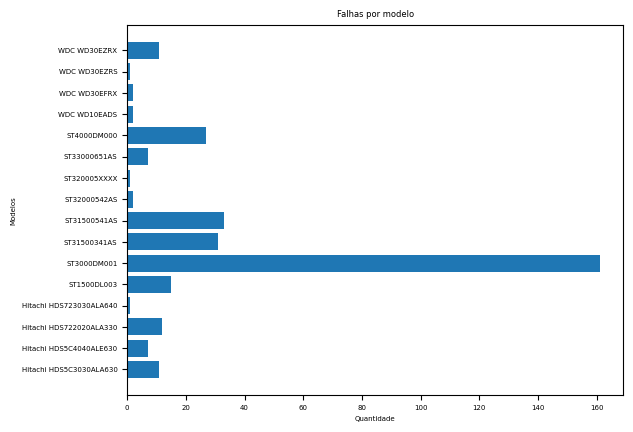

In [ ]:
#criando novo dataset somente com as ocorrências de falha
df_falhas = df_sem_colunas_normalizadas_dropna_columns[df_sem_colunas_normalizadas_dropna_columns['failure'] == 1]

#agrupando as falhas por model
df_count_falhas_p_model = pd.DataFrame(df_falhas.groupby('model').size()).reset_index()


plt.barh(df_count_falhas_p_model['model'], df_count_falhas_p_model[0])

plt.title("Falhas por modelo")

plt.xlabel("Quantidade")

plt.ylabel("Modelos")


Destaca-se nas unidades com falhas, as pertencentes ao modelo ST3000DM001, com ocorrências aproximadamente 4 vezes maior que o segundo colocado em falhas, mesmo o modelo ST3000DM001 sendo o terceiro em número de unidades.

In [ ]:
#agrupando as falhas por serial_number e realizando
df_count_falhas_p_serial_number = pd.DataFrame(df_falhas.groupby('serial_number').size()).reset_index()
#estatísticas básicas
print(df_count_falhas_p_serial_number.describe())
print('--------')
#primeiras linhas
print(df_count_falhas_p_serial_number.head())
print('--------')
#buscando no dataset original todas as ocorrências ddo serial_number='5XW1D4TT'
print(df_sem_colunas_normalizadas_dropna_columns[df_sem_colunas_normalizadas_dropna_columns['serial_number'] == '5XW1D4TT'])

           0
count  324.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
--------
  serial_number  0
0      5XW02KDD  1
1      5XW0JY2D  1
2      5XW0M6QE  1
3      5XW116TX  1
4      5XW1D4TT  1
--------
              date serial_number         model  capacity_bytes  failure  \
37296   2013-10-15      5XW1D4TT  ST31500541AS   1500301910016        0   
62269   2013-10-16      5XW1D4TT  ST31500541AS   1500301910016        0   
87243   2013-10-17      5XW1D4TT  ST31500541AS   1500301910016        0   
112218  2013-10-18      5XW1D4TT  ST31500541AS   1500301910016        0   
137193  2013-10-19      5XW1D4TT  ST31500541AS   1500301910016        0   
162257  2013-10-20      5XW1D4TT  ST31500541AS   1500301910016        0   
187322  2013-10-21      5XW1D4TT  ST31500541AS   1500301910016        0   
212476  2013-10-22      5XW1D4TT  ST31500541AS   1500301910016        1   

        smart_1_raw  smart_5_raw  smart_9_raw  smart_194_raw  smart_197_raw

Pelo describe() pode-se notar que somente existe uma falha por serial_number, valor min e max são 1. Analisando o dataset com as informações desse serial_number, percebe-se que após a falha o disco não retorna para atividade no período de tempo analisado.

Text(0, 0.5, 'Modelos')

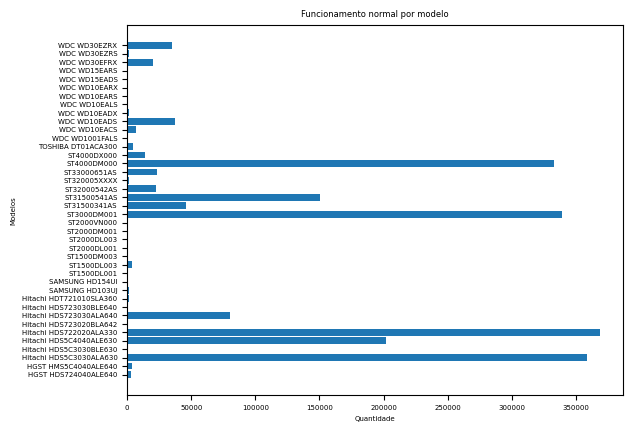

In [ ]:
#gerando dataset somente com os eventos de não falha
df_sem_falhas = df_sem_colunas_normalizadas_dropna_columns[df_sem_colunas_normalizadas_dropna_columns['failure'] == 0]

#agrupando por model os eventos
df_count_sem_falhas = pd.DataFrame(df_sem_falhas.groupby('model').size()).reset_index()

plt.barh(df_count_sem_falhas['model'], df_count_sem_falhas[0])

plt.title("Funcionamento normal por modelo")

plt.xlabel("Quantidade")

plt.ylabel("Modelos")

As unidades Hitachi parecem ser as com melhor desempenho, analisando os três últimos gráficos junta-se muitas unidades, com poucas falhas e grande quantidade de eventos sem falha, como visto neste último

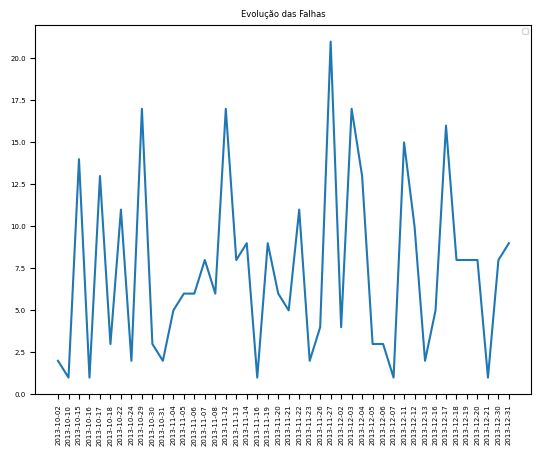

In [ ]:
#agrupando as falhas por data
df_count_falhas_p_data = pd.DataFrame(df_falhas.groupby('date').size()).reset_index()

#plotando  a evolução das falhas
plt.plot(df_count_falhas_p_data['date'], df_count_falhas_p_data[0])#label=atributo)

#rotacionando o eixo x para visualização
plt.xticks(rotation='vertical')

# incluindo título do gráfico e legenda
plt.title('Evolução das Falhas')
plt.legend();

A evolução de falhas no tempo não parece apresentar nenhuma tendência de um período com maior incidência, aparentando um comportamento aleatório, como esperado para esse tipo de componente.

### 3.2. Visualizações Unimodais

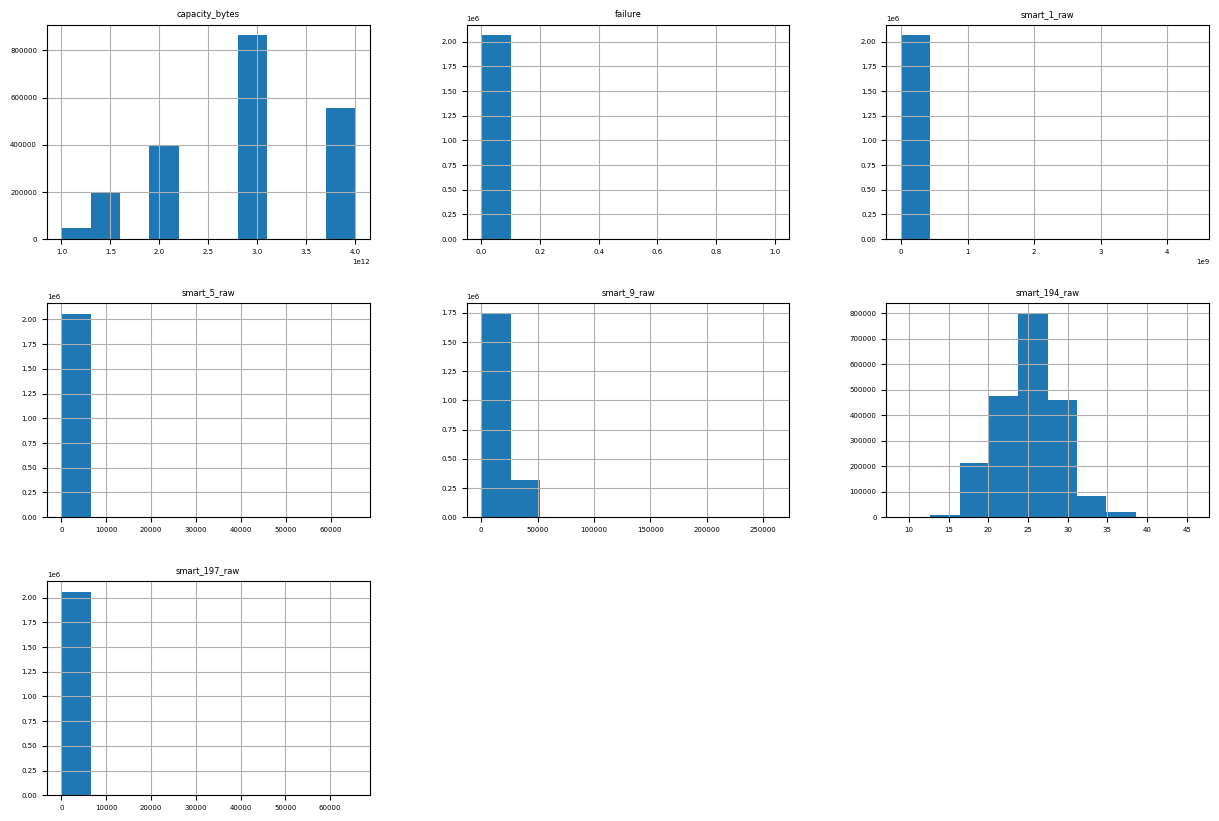

In [ ]:
df_sem_colunas_normalizadas_dropna_columns.hist(figsize = (15,10))
plt.show()

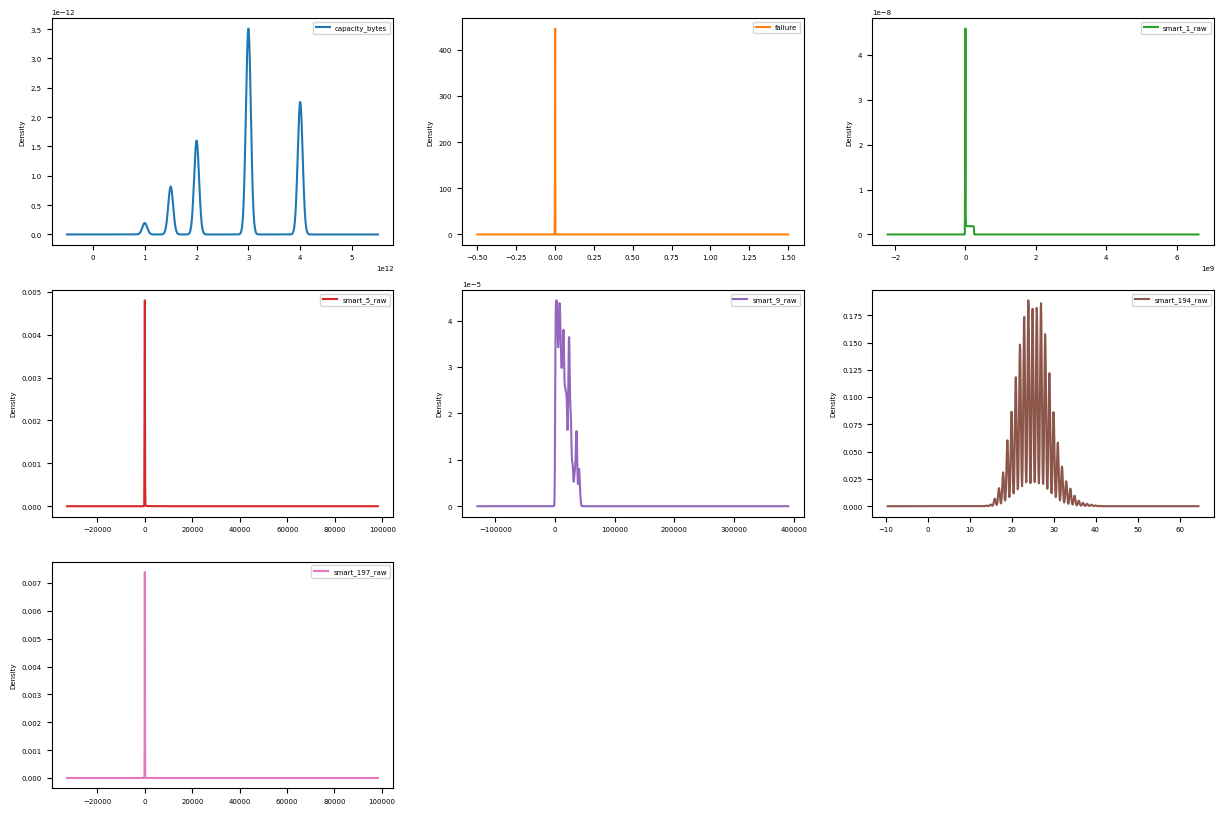

In [ ]:
df_sem_colunas_normalizadas_dropna_columns.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

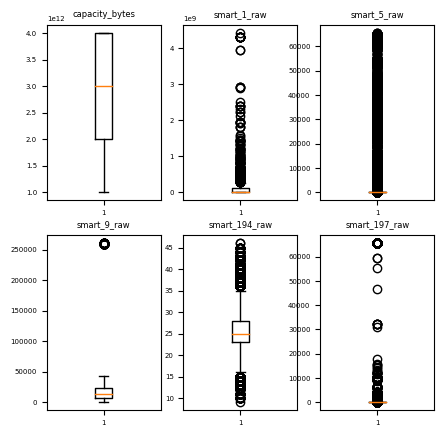

In [ ]:
# configurando um grupo de subplots em um grid de 2 linhas e 3 colunas
# e também o tamanho da figura
fig, ax = plt.subplots(2,3, figsize = (5, 5))

# subplot1: boxplot da capacidade de bytes
ax[0,0].boxplot(df_sem_colunas_normalizadas_dropna_columns['capacity_bytes'])
ax[0,0].set_title('capacity_bytes')

# subplot2: boxplot da smart_1
ax[0,1].boxplot(df_sem_colunas_normalizadas_dropna_columns['smart_1_raw'])
ax[0,1].set_title('smart_1_raw')

# subplot3: boxplot da smart_5
ax[0,2].boxplot(df_sem_colunas_normalizadas_dropna_columns['smart_5_raw'])
ax[0,2].set_title('smart_5_raw')

# subplot4: boxplot do smart_9
ax[1,0].boxplot(df_sem_colunas_normalizadas_dropna_columns['smart_9_raw'])
ax[1,0].set_title('smart_9_raw')

# subplot5: boxplot da smart_194
ax[1,1].boxplot(df_sem_colunas_normalizadas_dropna_columns['smart_194_raw']);
ax[1,1].set_title('smart_194_raw');

# subplot6: boxplot da smart_197
ax[1,2].boxplot(df_sem_colunas_normalizadas_dropna_columns['smart_197_raw']);
ax[1,2].set_title('smart_197_raw');

Observando os três gráficos anteriores,as distribuições da smart_9 e smart_194 são as únicas que possuem uma variabilidade de valores um perfil que pode ser aproximado de alguma das distribuições teóricas, verificado confirmado pelos boxplots.

As distribuições restantes das SMART apresentam uma gama muito estreita de valores, apresentadas como um linha vertical.

O gráfico de capacity_bytes indica que existem 5 faixas de capacidade de armazenamento, com predominância da faixa de 3TB.

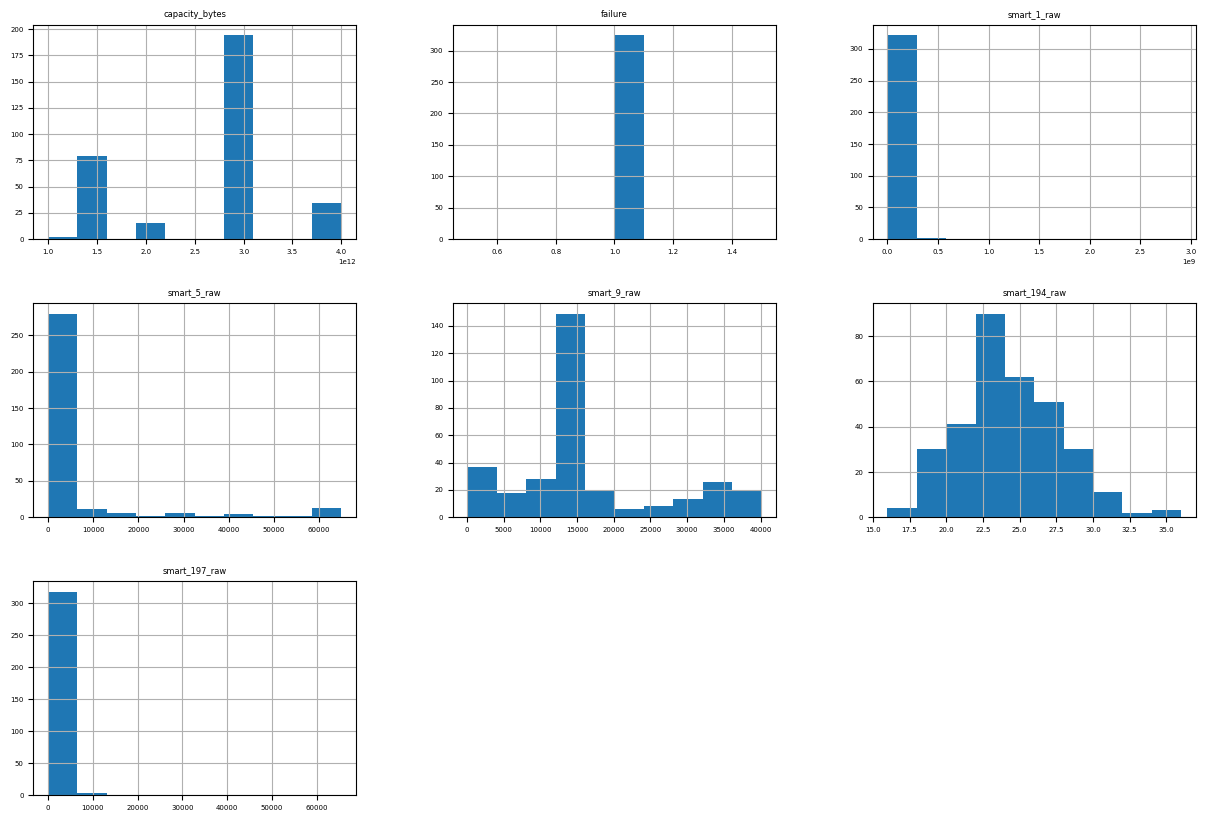

In [ ]:
#distribuição dos parametrôs para os eventos de falha
df_falhas.hist(figsize = (15,10))
plt.show()

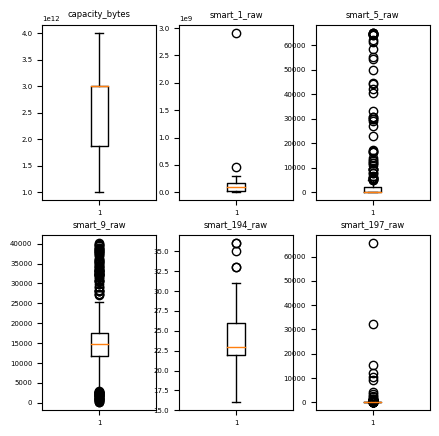

In [ ]:
# configurando um grupo de subplots em um grid de 2 linhas e 3 colunas
# e também o tamanho da figura
fig, ax = plt.subplots(2,3, figsize = (5, 5))

# subplot1: boxplot da capacidade de bytes
ax[0,0].boxplot(df_falhas['capacity_bytes'])
ax[0,0].set_title('capacity_bytes')

# subplot2: boxplot da smart_1
ax[0,1].boxplot(df_falhas['smart_1_raw'])
ax[0,1].set_title('smart_1_raw')

# subplot3: boxplot da smart_5
ax[0,2].boxplot(df_falhas['smart_5_raw'])
ax[0,2].set_title('smart_5_raw')

# subplot4: boxplot do smart_9
ax[1,0].boxplot(df_falhas['smart_9_raw'])
ax[1,0].set_title('smart_9_raw')

# subplot5: boxplot da smart_194
ax[1,1].boxplot(df_falhas['smart_194_raw']);
ax[1,1].set_title('smart_194_raw');

# subplot6: boxplot da smart_197
ax[1,2].boxplot(df_falhas['smart_197_raw']);
ax[1,2].set_title('smart_197_raw');

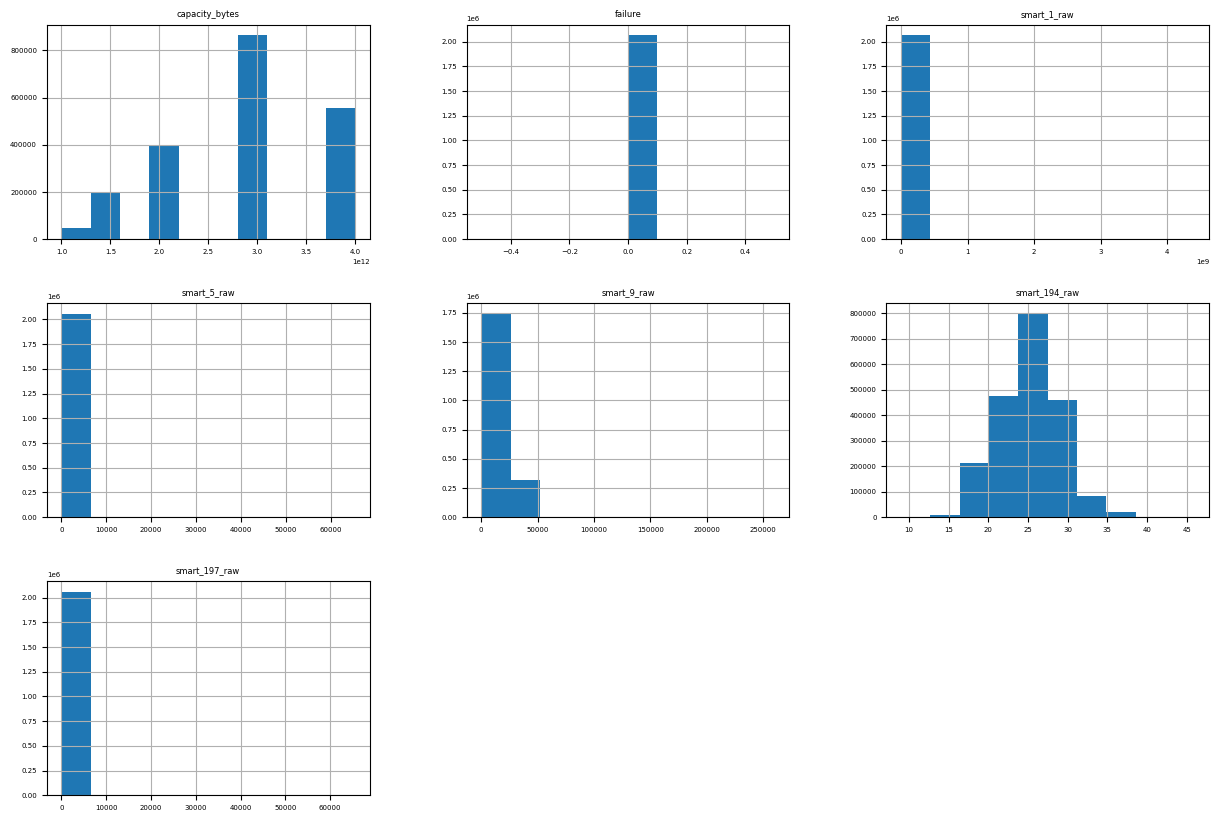

In [ ]:
df_sem_falhas.hist(figsize = (15,10))
plt.show()

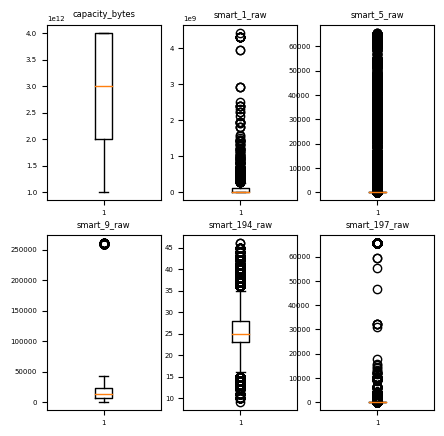

In [ ]:
# configurando um grupo de subplots em um grid de 2 linhas e 3 colunas
# e também o tamanho da figura
fig, ax = plt.subplots(2,3, figsize = (5, 5))

# subplot1: boxplot da capacidade de bytes
ax[0,0].boxplot(df_sem_falhas['capacity_bytes'])
ax[0,0].set_title('capacity_bytes')

# subplot2: boxplot da smart_1
ax[0,1].boxplot(df_sem_falhas['smart_1_raw'])
ax[0,1].set_title('smart_1_raw')

# subplot3: boxplot da smart_5
ax[0,2].boxplot(df_sem_falhas['smart_5_raw'])
ax[0,2].set_title('smart_5_raw')

# subplot4: boxplot do smart_9
ax[1,0].boxplot(df_sem_falhas['smart_9_raw'])
ax[1,0].set_title('smart_9_raw')

# subplot5: boxplot da smart_194
ax[1,1].boxplot(df_sem_falhas['smart_194_raw']);
ax[1,1].set_title('smart_194_raw');

# subplot6: boxplot da smart_197
ax[1,2].boxplot(df_sem_falhas['smart_197_raw']);
ax[1,2].set_title('smart_197_raw');

Comparando os gráficos com as distribuições para os eventos de falha e sem falha, se nota que as smart_9 e smart_194 são as únicas que apresentam alterações, parecendo indicar que são os de influência na falha dos discos. No entanto, o período utilizado no dataset é curto e a quantidade de informações SMART disponíveis é bem ampla, assim, mais dados seriam recomendados.

### 3.3. Visualizações Multimodais

Ao visualizar as correlações entre os atributos através da matriz de correlação, perceberemos que parece haver alguma estrutura na ordem dos atributos. O azul ao redor da diagonal sugere que os atributos que estão próximos um do outro são geralmente mais correlacionados entre si. Os vermelhos também sugerem alguma correlação negativa moderada, a medida que os atributos

Vamos agora verificar a covariância entre as variáveis numéricas do dataset. A **covariância** representa como duas variáveis numéricas estão relacionadas. Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis,
* Próximo de +1: há uma correlação positiva entre as variáveis.
* 0: não há correlação entre as variáveis.

A **matriz de correlação** exibe graficamente a correlação entre os atributos numéricos do dataset.estão mais distantes um do outro na ordenação.

<Axes: >

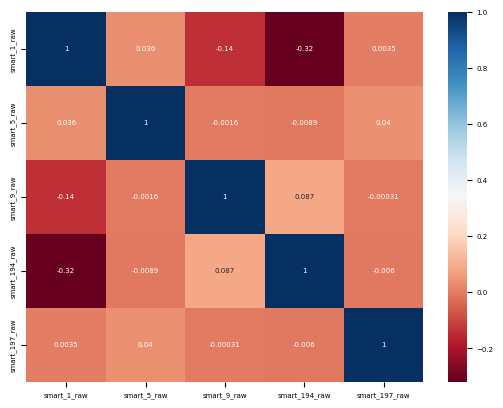

In [ ]:
# Matriz de Correlação com Matplotlib Seaborn
df_sem_failure_e_capacity = df_sem_colunas_normalizadas_dropna_columns.drop(['failure', 'capacity_bytes'], axis=1)
sns.heatmap(df_sem_failure_e_capacity.corr(), annot=True, cmap='RdBu')


O mapa não apresenta nenhuma indicação de boa correlação entre as variáveis, sendo os valores em módulo maiores sendo somente entre 0,14 e 0,32.

Por sua vez, o gráfico de dispersão (**scatter plot**) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

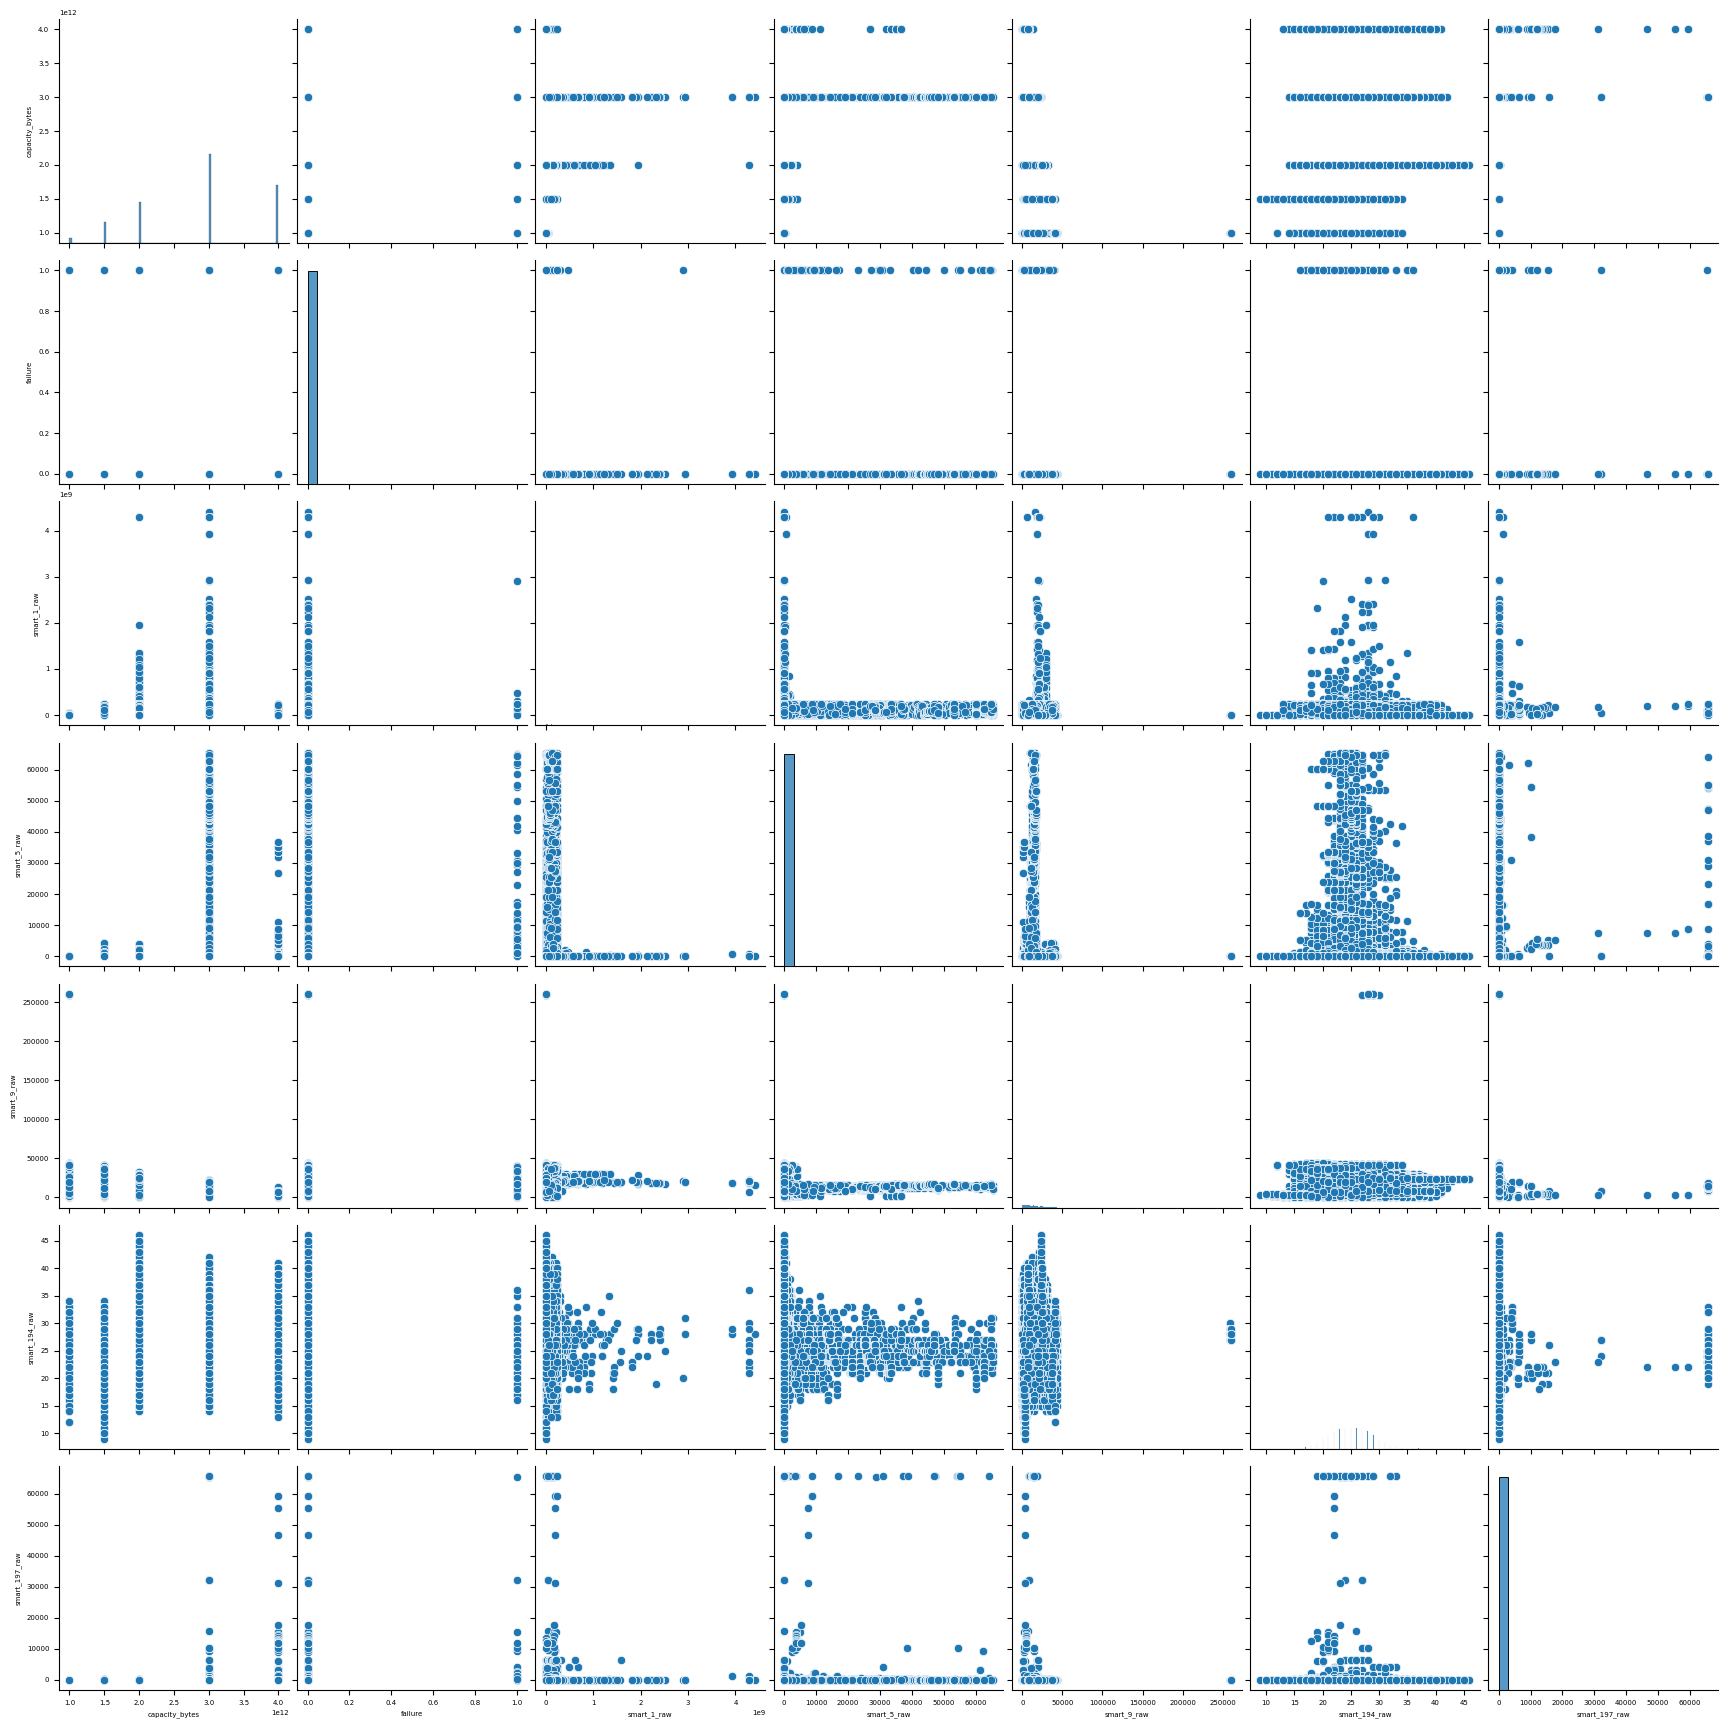

In [ ]:
# Scatter Plot com Seaborn - Variação 1
#df_sem_failure_e_capacity = df_sem_colunas_normalizadas_dropna_columns.drop(['failure', 'capacity_bytes'], axis=1)

sns.pairplot(df_sem_colunas_normalizadas_dropna_columns)

In [ ]:
dataset_minmax = df_sem_colunas_normalizadas_dropna_columns_npnan.values[:,5:10]

smart_197_raw_min_max = MinMaxScaler().fit_transform(dataset_minmax)
pd.DataFrame(smart_197_raw_min_max).plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()


## 4. Pré-Processamento de dados

### 4.1. Tratamento de Missings e Limpeza

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure           2061719
smart_1_raw        960408
smart_5_raw       1931608
smart_9_raw             0
smart_194_raw           0
smart_197_raw     2005158
dtype: int64
(2062043, 10)


<Axes: >

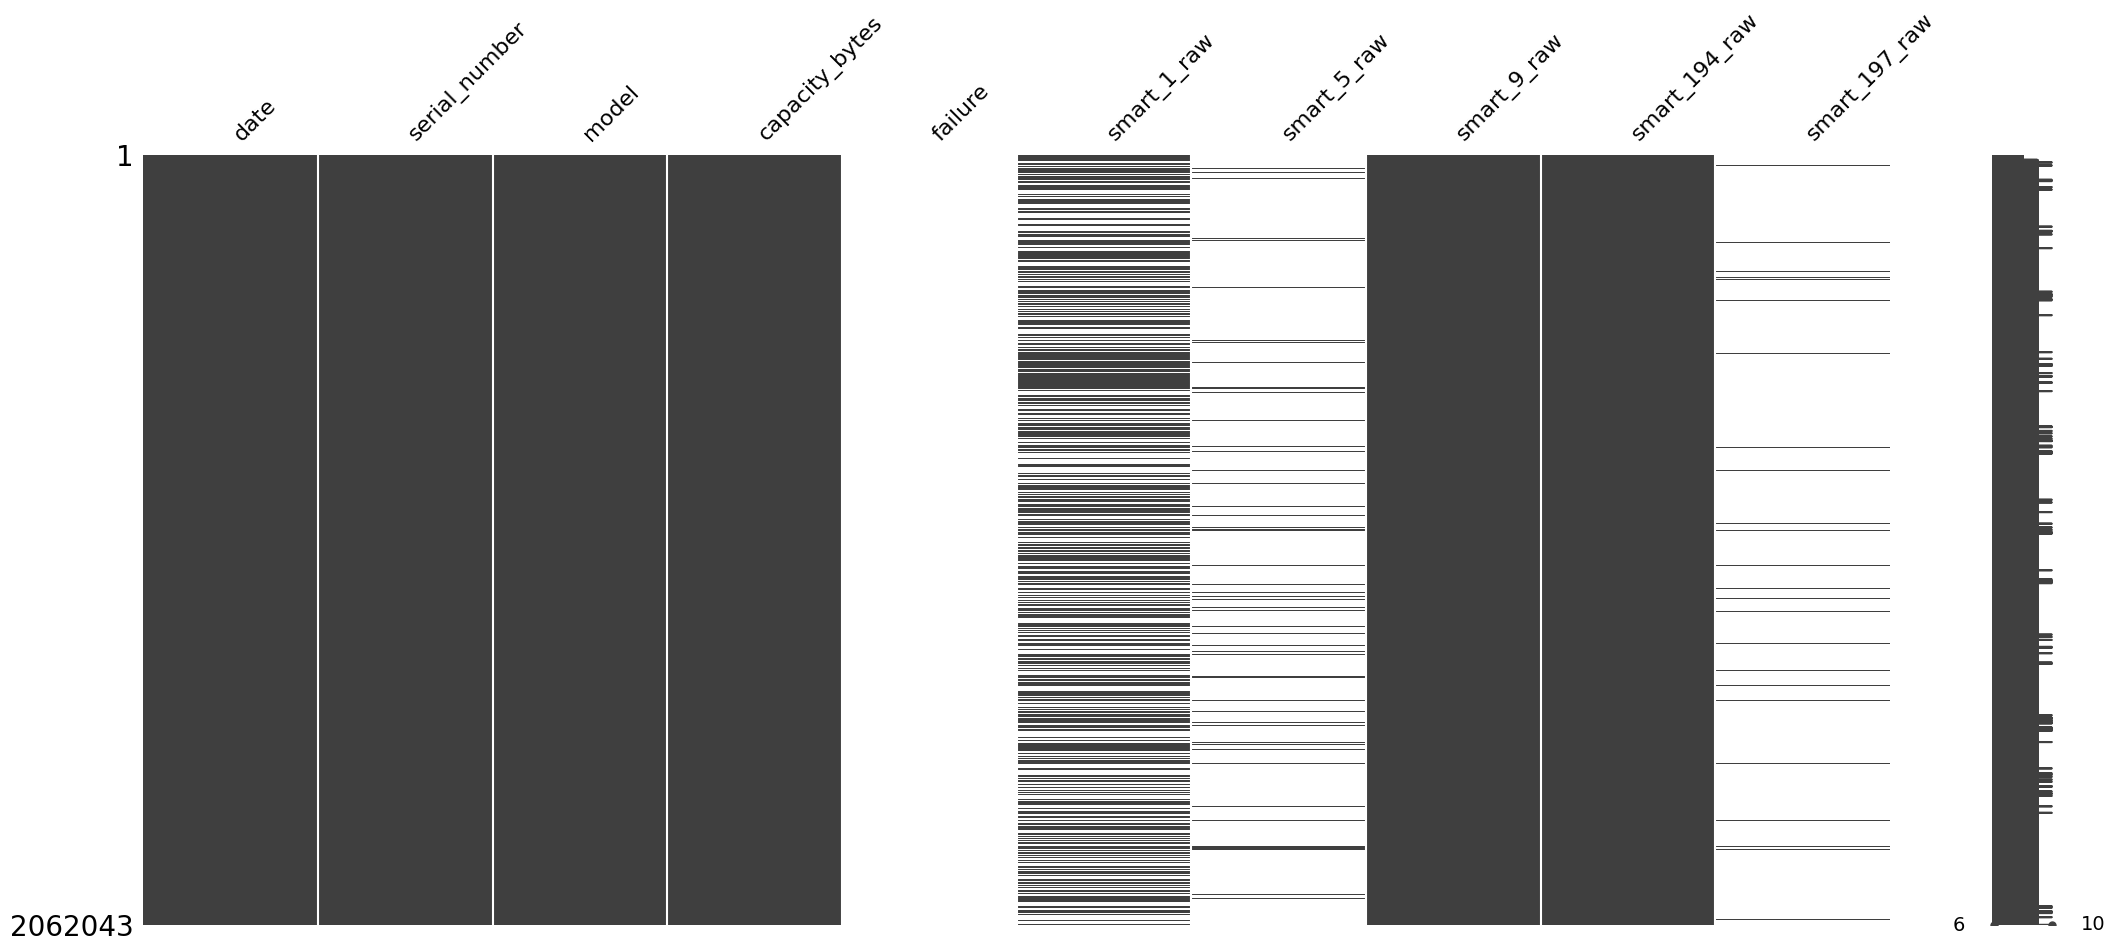

In [ ]:
#verificando a quantidade de zeros, substituindo os zeros por nulos
df_sem_colunas_normalizadas_dropna_columns_0_p_npnan = df_sem_colunas_normalizadas_dropna_columns.replace(0, np.nan)
print(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan.isnull().sum())
print(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan.shape)
ms.matrix(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan)

Algumas colunas como se pode notar, possuem muitos zeros. Mas no caso do dataset em questão, esses zeros não paracem ser missings e sim fazem realmente parte dos valores possíveis.No início desse trabalho, foi realizada a contagem de missings e exisitiam muitas colunas com eses dados, indicando que os zeros não os são. Assim, o tratamento dos zeros não tem necessidade de ser realizado pois se poderia contaminar o dataset.

date                0
serial_number       0
model               0
capacity_bytes      0
failure             0
smart_1_raw        23
smart_5_raw       146
smart_9_raw         0
smart_194_raw       0
smart_197_raw     171
dtype: int64
(324, 10)


<Axes: >

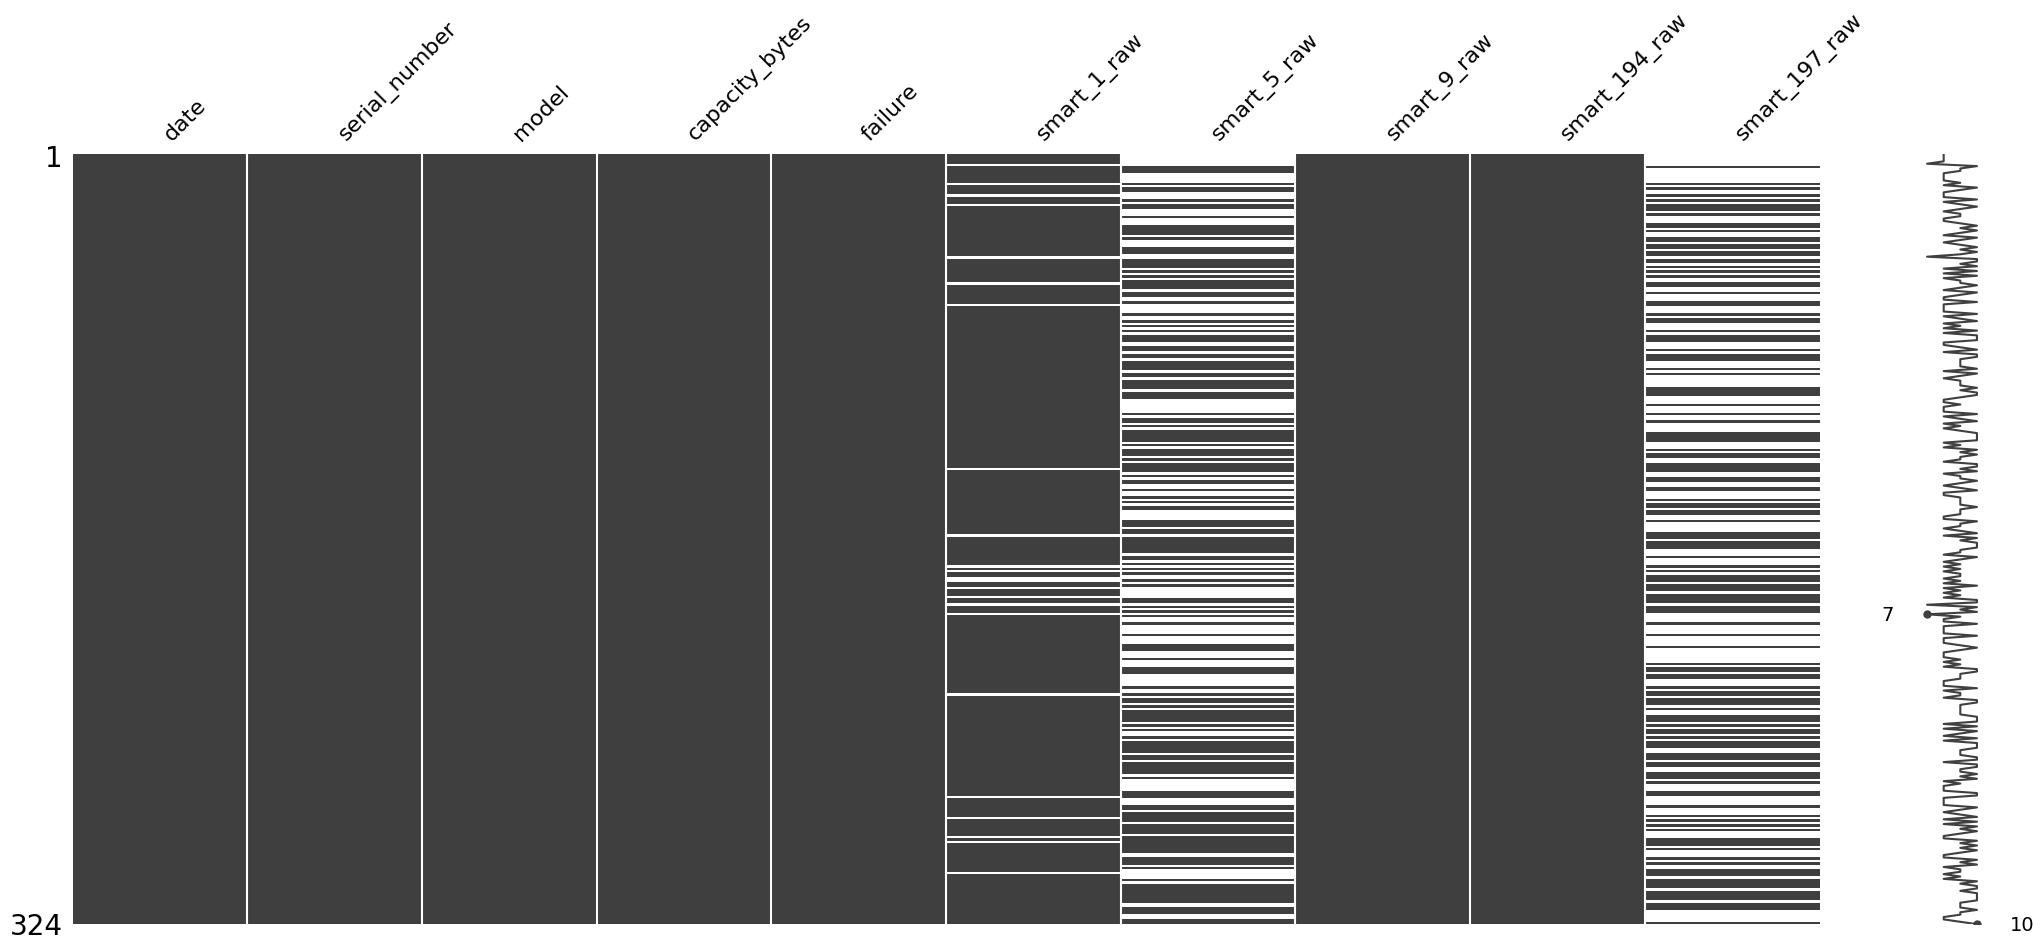

In [ ]:
#verificando a quantidade de zeros, substituindo os zeros por nulos nos eventos de falhas
df_falhas_0_p_npnan = df_falhas.replace(0, np.nan)
print(df_falhas_0_p_npnan.isnull().sum())
print(df_falhas_0_p_npnan.shape)
ms.matrix(df_falhas_0_p_npnan)

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure           2061719
smart_1_raw        960385
smart_5_raw       1931462
smart_9_raw             0
smart_194_raw           0
smart_197_raw     2004987
dtype: int64
(2061719, 10)


<Axes: >

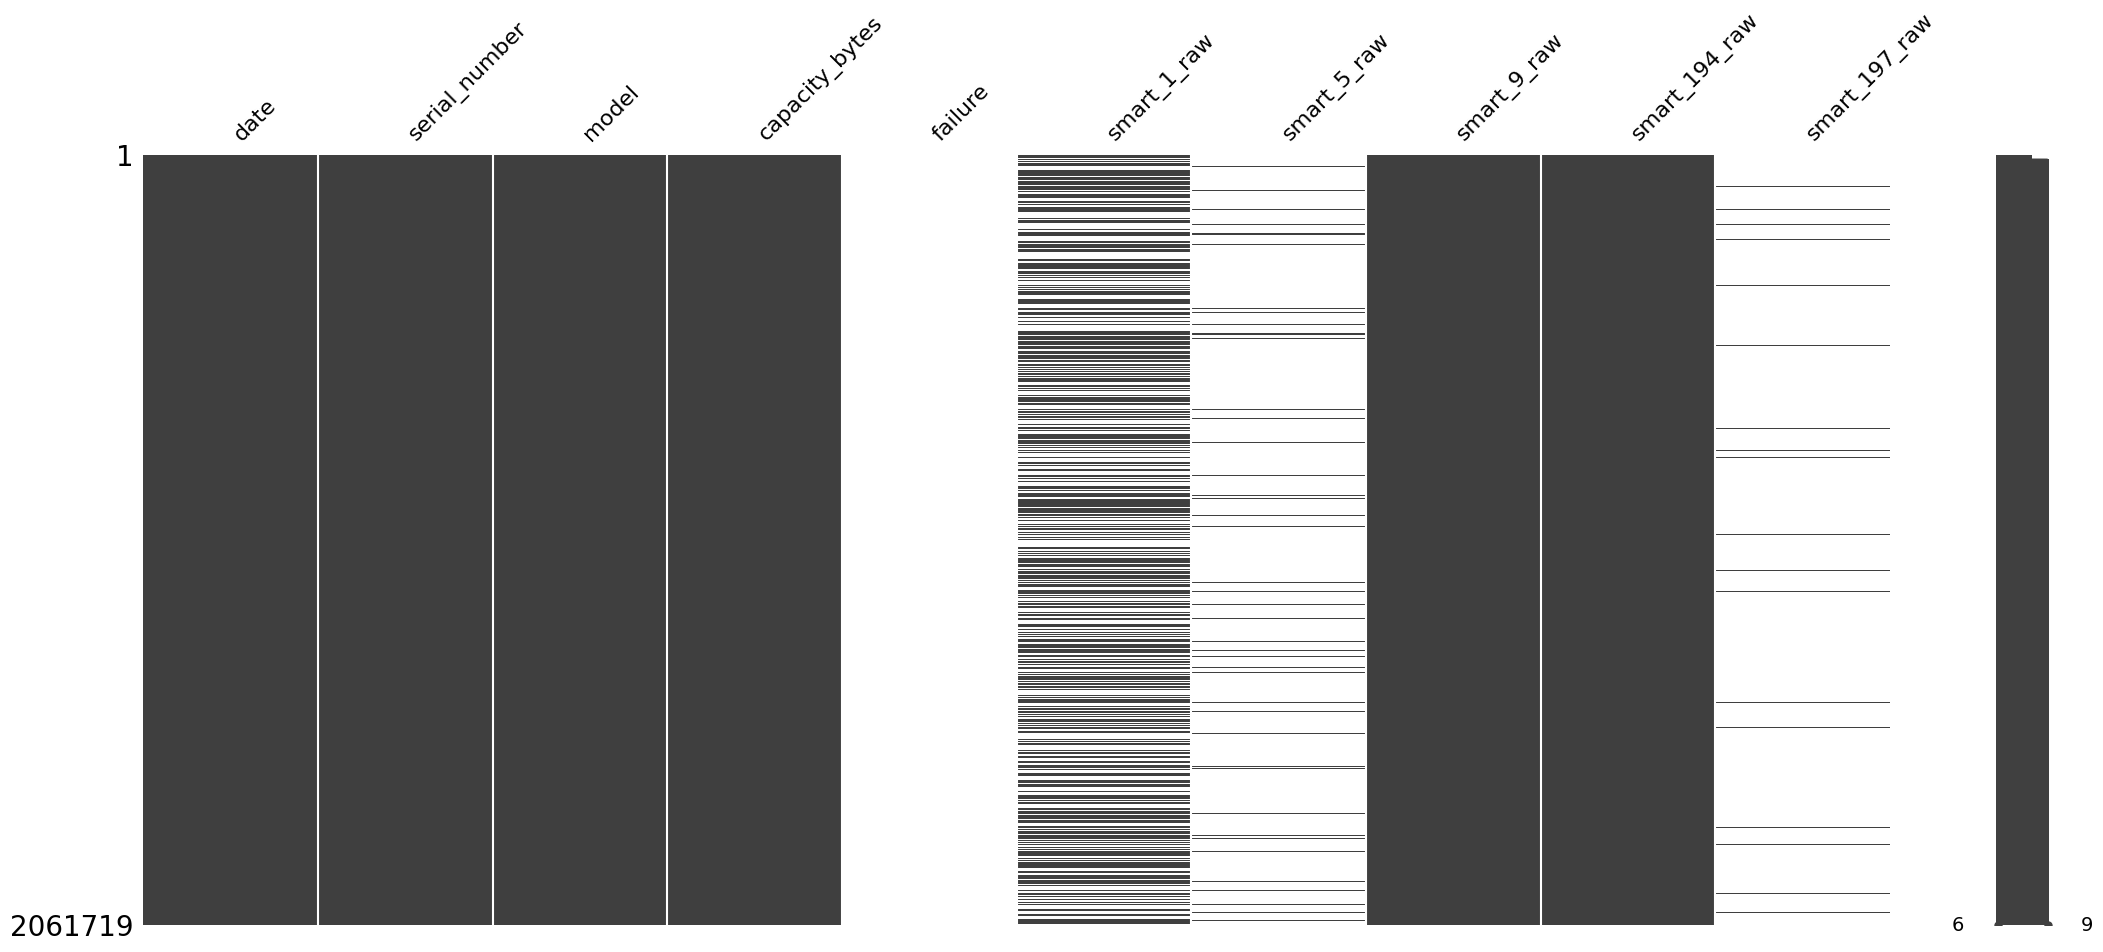

In [ ]:
#verificando a quantidade de zeros, substituindo os zeros por nulos nos eventos sem falhas
df_sem_falhas_0_p_npnan = df_sem_falhas.replace(0, np.nan)
print(df_sem_falhas_0_p_npnan.isnull().sum())
print(df_sem_falhas_0_p_npnan.shape)
ms.matrix(df_sem_falhas_0_p_npnan)

<Axes: >

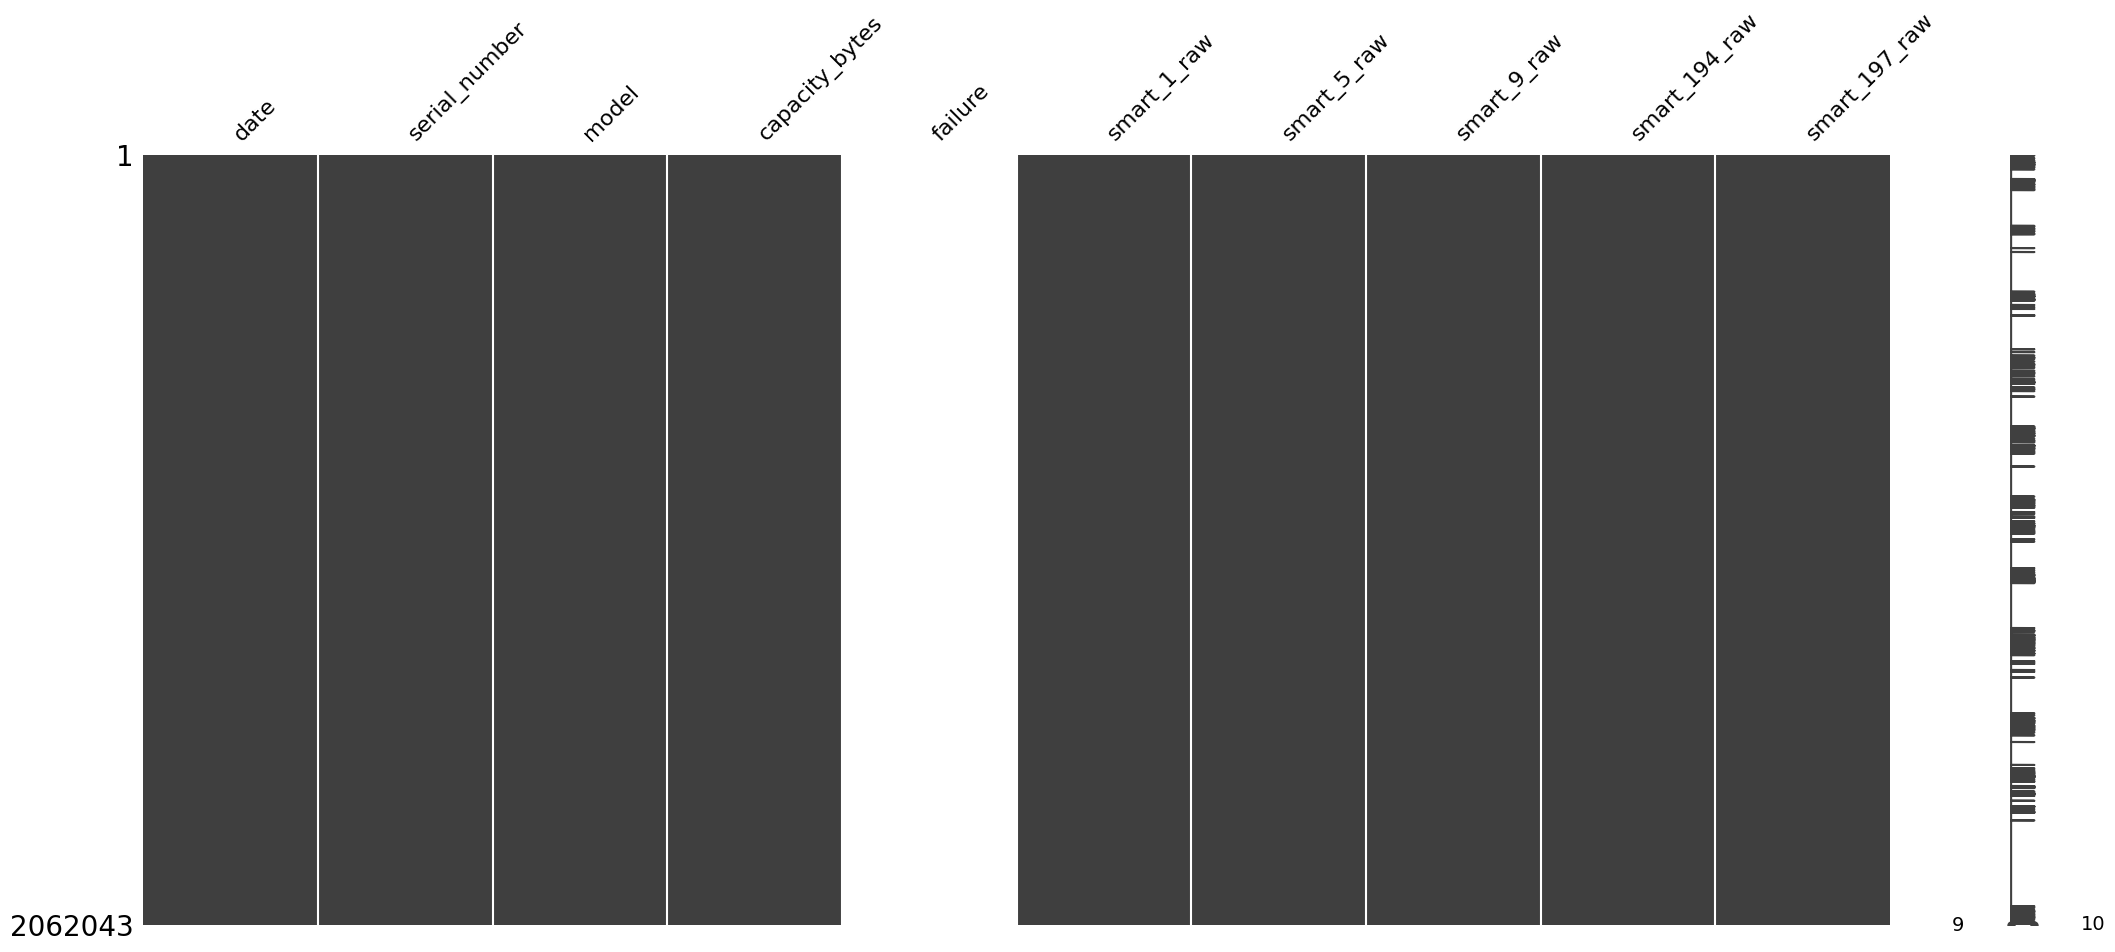

In [ ]:
# substituindo os NaN pela mediana da coluna
df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_1_raw'].fillna(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_1_raw'].median(), inplace = True)
df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_5_raw'].fillna(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_5_raw'].median(), inplace = True)
df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_197_raw'].fillna(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan['smart_197_raw'].median(), inplace = True)

# exibindo visualização matricial da nulidade do dataset
ms.matrix(df_sem_colunas_normalizadas_dropna_columns_0_p_npnan)

In [121]:
# tranformação categórica da classe modelo
encoded_X = OrdinalEncoder().fit_transform(df_sem_colunas_normalizadas_dropna_columns['model'].head().values[:,].reshape(-1,1))

A transformação categórica visa a utilização de variáveis de classe no vetor de entrada do modelo de ML, aqui temos a transformação da coluna modelo para vetor númerico

### 4.2. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste (na literatura também chamado de conjunto de validação), uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos. Usaremos 80% do conjunto de dados para modelagem e guardaremos 20% para teste, usando a estratégia train-test-split, já explicada anteriormente. Primeiramente, iremos sinalizar quais são as colunas de atributos (X -  , capacity_bytes, model, smart_1_raw, smart_5_raw, smart_9_raw, smart_194_raw, smart_197_raw, ) e qual é a coluna das classes (Y - 0 - 'failure'). Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados). Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: os atributos e classes para o conjunto de teste e os atributos e classes para o conjunto de treino.
No caso de dataset da Backblaze um rebalanceamento pode ser necessário, devido à grande quantidade de não falhas em comparação com as falhas encontradas.


Como o dataset é grande e com todas as análises sem deletar os dataframes paralelos, o colab está com a RAM no limite. Assim, essa parte final será realizada com menos dados e aplicado nos próximos mvps para otimizar o processamento

In [128]:
#9 colunas values
#df_sem_colunas_normalizadas_dropna_columns.values[10,(0,1,2,3,4,5,6,7,8,9)]
#df_sem_colunas_normalizadas_dropna_columns.values[0:10,(2,3,4,5,6,7,8,9)]

test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste (dataset original)

X = df_sem_colunas_normalizadas_dropna_columns.values[0:10,(2,3,5,6,7,8,9)]
y = df_sem_colunas_normalizadas_dropna_columns.values[0:10,(4)]
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#    test_size=test_size, shuffle=True, random_state=seed) # sem estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # com estratificação

## 5. Conclusão

Nesse trabalho se analisou um grande dataset contendo estatísticas de utilização de discos em datacenters da empresa Backblaze, os dados são disponibilizados gratuitamente desde 2013 e separados por dia.

Como o dataset original é muito grande e não suportado pelo colab, foram selecionados os dados de 3 meses do ano de 2013. O dataset contém dados numéricos e categóricos, com uma aplicação extremamete interessante na previsão de falhas nas unidades. A grande quantidade de indicadores SMART, que são tradicionais nesse tipo de equipamento, são imensas, no entanto, no selecionado para o trabalho com as análises realizadas se pode notar que apenas dois desses paracem ser importantes para a indicação de falha.

Na análise de modelos e falhas, também foi possível verificar no intervalo analizado, que as unidades Hitachi tem indícios de serem as melhores no contexto geral, como já citado.

A questão temporal, ou seja, os meses do ano não parecem indicar influência no aumento ou diminuição da tendência de falhas.

Uma dificuldade encontrada foi a pequena quantidade de falhas em comparação com a grande quantidade não falhas, indicando a possível necessidade de um rebalanceamento para utiliação em um modelo. Esse grande número de dados dificultou a questão de utilização da memória RAM do colab, dificuldade que não gera aprendizado, levando a se considerar a troca ou reformulação do dataset para as outras atividades.

As unidades em falha não foram repostas no período analisado, fato comprovado na análise dos eventos.

Conluindo o trabalho, percebe-se a grande utilidade da análise exploratória, os insights com respeito aos dados mais importantes para o modelo que visam o menor recurso computacinal foram obtidos, claro não sendo possível a generalização pois os meses eram poucos. Além de informações mais simples, mas tão importantes quanto, como unidades com melhor desempenho puderam ser obtidas nessa etapa inicial.